# Django ORM Performance Optimization

- The N+1 Queries Problem
- Over-querying
- Doing too much "in Python"

## Setup

In [ ]:
import time
import os
os.environ["DJANGO_SETTINGS_MODULE"] = "django_orm_performance_demo.settings"

import sqlparse

import django

from django.db import connection
django.setup()

# Disable errors about SynchronousOnlyOperation
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [ ]:
"""Init Logging"""
import logging
import sys

from collections import defaultdict

ALL_QUERIES = []
UNIQUE_QUERIES = defaultdict(int)

class SqlLoggerHandler(logging.Handler):
    def __init__(self, level=logging.NOTSET):
        super(self.__class__, self).__init__(level)

    def emit(self, record):
        try:
            # msg = self.format(record.sql)
            formatted_sql = sqlparse.format(record.sql, reindent=True, keyword_case='upper')
            sys.stdout.flush()
            print(formatted_sql, file=sys.stderr, flush=True)
            ALL_QUERIES.append(record)
            
            UNIQUE_QUERIES[record.sql] += 1
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            self.handleError(record)
        

db_logger = logging.getLogger("django.db.backends")
db_logger.setLevel(logging.DEBUG)
console_handler = SqlLoggerHandler()
console_handler.setFormatter(logging.Formatter("%(levelname)s %(asctime)s %(message)s"))
db_logger.addHandler(console_handler)

In [ ]:
class Benchmark:
    def __init__(self, description=None, logger=None):
        # Reset ALL_QUERIES
        global ALL_QUERIES
        ALL_QUERIES = []
        # Reset UNIQUE_QUERIES
        global UNIQUE_QUERIES
        UNIQUE_QUERIES = defaultdict(int)

        self.start_time = time.perf_counter()
        self.num_initial_queries = len(ALL_QUERIES)
        self.logger = logger if logger else print
        self.description = "Did stuff" if description is None else description

    def __enter__(self):
        pass

    def __exit__(self, type, value, traceback):
        end_time = time.perf_counter()
        num_final_queries = len(ALL_QUERIES)
        num_queries = num_final_queries - self.num_initial_queries
        total_query_time = sum(float(q.duration) for q in ALL_QUERIES)
        self.logger(
            f"{self.description}: {num_queries} quer{'y' if num_queries == 1 else 'ies'} "
            f"({len(UNIQUE_QUERIES)} unique) in {total_query_time:.3f} seconds; "
            f"{end_time - self.start_time:.4f} seconds total",
            flush=True
        )


## Background

### Intro to Django ORM

For those who have never used Django before, here's a very quick intro to its ORM (model layer)

This is the `person` database table:

```plain
                         Table "public.people_person"
 Column  |  Type  |                         Modifiers                          
---------+--------+------------------------------------------------------------
 id      | bigint | not null default nextval('people_person_id_seq'::regclass)
 name    | text   | not null
 notes   | text   | not null
 site_id | bigint | not null
Indexes:
    "people_person_pkey" PRIMARY KEY, btree (id)
    "people_person_site_id_4c070efc" btree (site_id)
Foreign-key constraints:
    "people_person_site_id_4c070efc_fk_people_site_id" FOREIGN KEY (site_id) REFERENCES people_site(id) DEFERRABLE INITIALLY DEFERRED
```

And here is the `Person` model. This was used to generate the above schema, and is also used to interact with it at runtime.

```python
class Person(models.Model):
    name = models.TextField()
    site = models.ForeignKey("Site", on_delete=models.CASCADE)
    notes = models.TextField()
```


This is the full model layer we will be using:

```python
from django.db import models


class Person(models.Model):
    name = models.TextField()
    site = models.ForeignKey("Site", on_delete=models.CASCADE)
    notes = models.TextField()

    def __str__(self):
        return self.name


class Observatory(models.Model):
    name = models.TextField()

    def __str__(self):
        return self.name


class Site(models.Model):
    name = models.TextField()
    observatory = models.ForeignKey("Observatory", on_delete=models.CASCADE)

    def __str__(self):
        return self.name
```

Or in ERD form:

![People Models ERD](./people_erd.png)

## Basic Queries

### Count People

It is trivial to construct a query using the Django ORM. For example, to find out how many `Person`s are in the database, we can:

In [ ]:
from people.models import Person

def count_people():
    Person.objects.count()

with Benchmark("count_people"):
    count_people()

SELECT COUNT(*) AS "__count"
FROM "people_person"


count_people: 1 query (1 unique) in 0.007 seconds; 0.0378 seconds total


Easy enough -- this is pretty much what you would write by hand

## Print People

Let's print the first 5 people in the database

In [ ]:
from people.models import Person


def print_5_people():
    # Construct QuerySet
    first_five_people = Person.objects.all()[:5]
    # Evaluate QuerySet and 
    for person in first_five_people:
        print(person)
    print()
    
with Benchmark("print_5_people"):
    print_5_people()

SELECT "people_person"."id",
       "people_person"."name",
       "people_person"."site_id",
       "people_person"."notes"
FROM "people_person"
LIMIT 5


Catherine Barry
Joel Moore
Mark Barber
Pamela Crane
Heather Reynolds

print_5_people: 1 query (1 unique) in 0.004 seconds; 0.0105 seconds total


What happened?

1. Django constructed a `QuerySet` from `Person.objects.all()[:5]`
2. Django evaluated the `QuerySet` (excuted the query and populated the relevant attributes of each `Model` instance in the `QuerySet`)

## The N+1 Problem

What happens if we try to print an attribute of a `Person` instance that _isn't_ already populated? Well, Django needs to fetch it from the database!

In [ ]:
from people.models import Person

def print_n_people(n):
    # Construct QuerySet
    first_five_people = Person.objects.all()[:n]
    # Evaluate QuerySet and 
    for person in first_five_people:
        print(person, person.site)
    print()
    
with Benchmark("print_n_people"):
    print_n_people(2)

SELECT "people_person"."id",
       "people_person"."name",
       "people_person"."site_id",
       "people_person"."notes"
FROM "people_person"
LIMIT 2
SELECT "people_site"."id",
       "people_site"."name",
       "people_site"."observatory_id"
FROM "people_site"
WHERE "people_site"."id" = 3
LIMIT 21


Catherine Barry Charlottesville


SELECT "people_site"."id",
       "people_site"."name",
       "people_site"."observatory_id"
FROM "people_site"
WHERE "people_site"."id" = 2
LIMIT 21


Joel Moore Socorro

print_n_people: 3 queries (3 unique) in 0.003 seconds; 0.0209 seconds total


## Mitigations to the N+1 Problem

### "Naive" Base Case

Let's start with a slight modification to the above. We are generating a list of person/observatory/site strings. The naive implementation results in 2N+1 queries:

In [ ]:
from people.models import Person

def get_people_naive(people):
    """List person/observatory/site using "naive" iteration of Person QuerySet"""
    return [
        f"{person.name}: {person.site.observatory.name}, {person.site.name}"
        for person in people.all()
    ]
with Benchmark("get_people_naive"):
    get_people_naive(Person.objects.all()[:2])

SELECT "people_person"."id",
       "people_person"."name",
       "people_person"."site_id",
       "people_person"."notes"
FROM "people_person"
LIMIT 2
SELECT "people_site"."id",
       "people_site"."name",
       "people_site"."observatory_id"
FROM "people_site"
WHERE "people_site"."id" = 3
LIMIT 21
SELECT "people_observatory"."id",
       "people_observatory"."name"
FROM "people_observatory"
WHERE "people_observatory"."id" = 2
LIMIT 21
SELECT "people_site"."id",
       "people_site"."name",
       "people_site"."observatory_id"
FROM "people_site"
WHERE "people_site"."id" = 2
LIMIT 21
SELECT "people_observatory"."id",
       "people_observatory"."name"
FROM "people_observatory"
WHERE "people_observatory"."id" = 2
LIMIT 21


get_people_naive: 5 queries (4 unique) in 0.003 seconds; 0.0276 seconds total


### `QuerySet.select_related()`

[From the Django QuerySet documentation:](https://docs.djangoproject.com/en/3.2/ref/models/querysets/#select-related)

> Returns a QuerySet that will “follow” foreign-key relationships, selecting additional related-object data when it executes its query. This is a performance booster which results in a single more complex query but means later use of foreign-key relationships won’t require database queries.



In [14]:
from people.models import Person

def get_people_select_related(people):
    """List person/observatory/site via iteration of QuerySet using select_related"""
    return [
        f"{person.name}: {person.site.observatory.name}, {person.site.name}"
        for person in people.select_related("site__observatory").all()
    ]
with Benchmark("get_people_select_related"):
    get_people_select_related(Person.objects.all()[:2])

SELECT "people_person"."id",
       "people_person"."name",
       "people_person"."site_id",
       "people_person"."notes",
       "people_site"."id",
       "people_site"."name",
       "people_site"."observatory_id",
       "people_observatory"."id",
       "people_observatory"."name"
FROM "people_person"
INNER JOIN "people_site" ON ("people_person"."site_id" = "people_site"."id")
INNER JOIN "people_observatory" ON ("people_site"."observatory_id" = "people_observatory"."id")
LIMIT 2


get_people_select_related: 1 query (1 unique) in 0.002 seconds; 0.0142 seconds total


Indeed, we have a more complicated query here: two joins, in order to determine the site and observatory names for each person

You might be wondering: why are we grabbing _all_ of the columns from each table? Well, Django doesn't know which columns you might want, so it grabs them all!

This is important -- QuerySets are often described as _lazy_, but they are actually _greedy_ in this context!

However, there is a solution...

### `QuerySet.defer()` and `QuerySet.only()`

Both of these methods tell Django to fetch only a subset of the fields for the given model when evaluating a `QuerySet`. `QuerySet.defer()` requests all fields _except_ those given; `QuerySet.only()`  requests _only_ the given fields.

For us, the field we want to exclude is the `Person.notes` field, which contains a large block of text, and which we are not using at all. We _could_ defer _just_ the `Person.notes` field... but given that we know _exactly_ which fields we need, we can safely use `QuerySet.only()`

[See also the Django QuerySet documentation on `QuerySet.only()`](https://docs.djangoproject.com/en/3.2/ref/models/querysets/#django.db.models.query.QuerySet.only)

In [9]:
from people.models import Person

def get_people_select_related_only(people):
    """List person/observatory/site via iteration of QuerySet.only()"""
    return [
        f"{person.name}: {person.site.observatory.name}, {person.site.name}"
        for person in Person.objects.select_related("site__observatory")
        .only("name", "site_id")
        .all()
    ]
with Benchmark("get_people_select_related_only"):
    people = get_people_select_related_only(Person.objects.all()[:2])

SELECT "people_person"."id",
       "people_person"."name",
       "people_person"."site_id",
       "people_site"."id",
       "people_site"."name",
       "people_site"."observatory_id",
       "people_observatory"."id",
       "people_observatory"."name"
FROM "people_person"
INNER JOIN "people_site" ON ("people_person"."site_id" = "people_site"."id")
INNER JOIN "people_observatory" ON ("people_site"."observatory_id" = "people_observatory"."id")


get_people_select_related_only: 1 query (1 unique) in 0.022 seconds; 0.2914 seconds total


We can see that using `QuerySet.defer()` gives us an identical query:

In [10]:
def get_people_select_related_defer(people):
    """List person/observatory/site via iteration of QuerySet.only()"""
    return [
        f"{person.name}: {person.site.observatory.name}, {person.site.name}"
        for person in people.select_related("site__observatory")
        .defer("notes")
        .all()
    ]
with Benchmark("get_people_select_related_defer"):
    people = get_people_select_related_defer(Person.objects.all()[:2])

SELECT "people_person"."id",
       "people_person"."name",
       "people_person"."site_id",
       "people_site"."id",
       "people_site"."name",
       "people_site"."observatory_id",
       "people_observatory"."id",
       "people_observatory"."name"
FROM "people_person"
INNER JOIN "people_site" ON ("people_person"."site_id" = "people_site"."id")
INNER JOIN "people_observatory" ON ("people_site"."observatory_id" = "people_observatory"."id")
LIMIT 2


get_people_select_related_defer: 1 query (1 unique) in 0.001 seconds; 0.0070 seconds total


### `QuerySet.values()`

Performance is now "pretty good". However, for many use cases we can speed up by ~5x by using `QuerySet.values()` to create a "list of dicts", rather than a "list of model instances".

The huge caveat here is that _we no longer have access to our model instances_. So, no model methods or non-field attributes are available to us. The challenge, then, is working around that limitation.

In [11]:
from people.models import Person

def get_people_values(people):
    """List person/observatory/site using explict retrieval of relevant values"""
    return [
        (name, observatory, site)
        for name, site, observatory in people.values_list(
            "name", "site__name", "site__observatory__name"
        )
    ]
with Benchmark("get_people_values"):
    people = get_people_values(Person.objects.all()[:2])

SELECT "people_person"."name",
       "people_site"."name",
       "people_observatory"."name"
FROM "people_person"
INNER JOIN "people_site" ON ("people_person"."site_id" = "people_site"."id")
INNER JOIN "people_observatory" ON ("people_site"."observatory_id" = "people_observatory"."id")
LIMIT 2


get_people_values: 1 query (1 unique) in 0.001 seconds; 0.0049 seconds total


In [12]:
db_logger.setLevel(logging.DEBUG)
def get_people_qs_only(people):
    """List person/observatory/site via iteration of QuerySet.only()"""
    return [
        (person, person.site.observatory, person.site)
        for person in people.only("name", "site_id").all()
    ]

with Benchmark("get_people_qs_only"):
    qs = get_people_qs_only(Person.objects.all()[:2])


SELECT "people_person"."id",
       "people_person"."name",
       "people_person"."site_id"
FROM "people_person"
LIMIT 2
SELECT "people_site"."id",
       "people_site"."name",
       "people_site"."observatory_id"
FROM "people_site"
WHERE "people_site"."id" = 3
LIMIT 21
SELECT "people_observatory"."id",
       "people_observatory"."name"
FROM "people_observatory"
WHERE "people_observatory"."id" = 2
LIMIT 21
SELECT "people_site"."id",
       "people_site"."name",
       "people_site"."observatory_id"
FROM "people_site"
WHERE "people_site"."id" = 2
LIMIT 21
SELECT "people_observatory"."id",
       "people_observatory"."name"
FROM "people_observatory"
WHERE "people_observatory"."id" = 2
LIMIT 21


get_people_qs_only: 5 queries (4 unique) in 0.002 seconds; 0.0152 seconds total


## Benchmarks


                         Function  # People       Time  vs. Fastest
4               get_people_values     10000   0.014453     1.000000
3  get_people_select_related_only     10000   0.211937    14.663887
2       get_people_select_related     10000   1.986562   137.449898
1              get_people_qs_only     10000  14.585371  1009.159352
0                get_people_naive     10000  17.166587  1187.753227


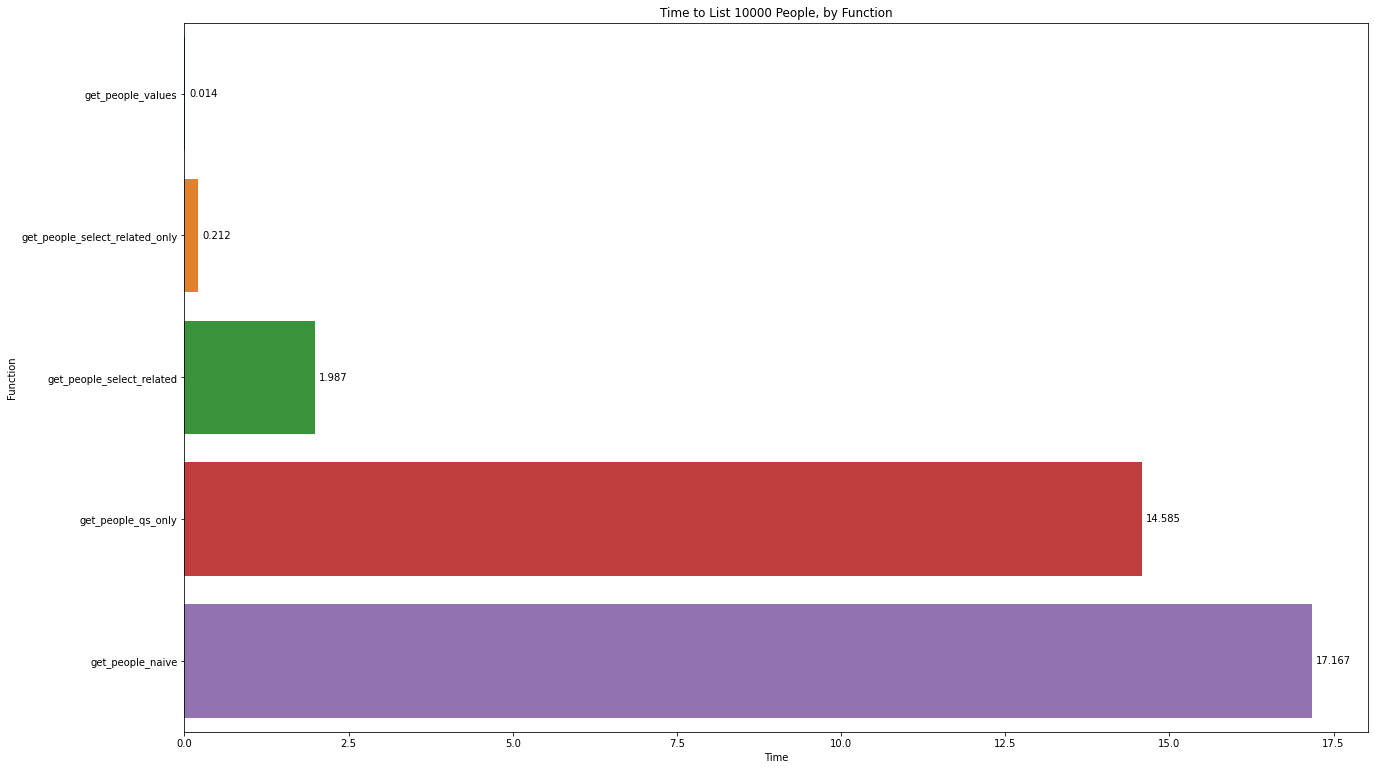

In [13]:
db_logger.setLevel(logging.WARNING)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import timeit
from functools import partial

def bench_people(trials, func, num_people):
    if Person.objects.count() < num_people:
        raise ValueError("You need to generate more people!")

    return min(
        timeit.repeat(
            partial(func, Person.objects.all()[:num_people]),
            number=1,
            repeat=trials,
        )
    )

def plot_people(df):
    fig, axes = plt.subplots(figsize=(19.2, 10.8))

    ax = sns.barplot(data=df, y="Function", x="Time")
    ax.set_title(f"Time to List {df['# People'][0]} People, by Function")
    ax.bar_label(ax.containers[0], fmt='%.3f', padding=4)
    # ax.set_xlim(0, 20)
    fig.tight_layout()

to_test = [
    get_people_naive,
    get_people_qs_only,
    get_people_select_related,
    get_people_select_related_only,
    get_people_values,
]

num_trials = 2
num_people = 10_000
results = [
    (
        func.__name__,
        num_people,
        bench_people(num_trials, func, num_people),
    )
    for func in to_test
]
df = pd.DataFrame(results, columns=["Function", "# People", "Time"]).sort_values("Time")
df["vs. Fastest"] = df["Time"] / df["Time"].min()
print(df)
plot_people(df)
plt.show()

As we can see, `get_people_values` is the fastest, by a wide margin

## Summary

- Avoid the N+1 problem (unless you have concrete benchmarks telling you otherwise)
    - When possible, use `QuerySet.values()`
    - When you must use model instances, make use of `QuerySet.select_related()`
    - Use `QuerySet.defer()` and `QuerySet.only()` _only_ if you have significant time savings (e.g. a massive `notes` field that you don't actually use...)